 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations.


## But first... Theory
Solve the theoretical problems. Type the solutions here, using Latex

### Problem 1 (2 points)

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

#### Solution

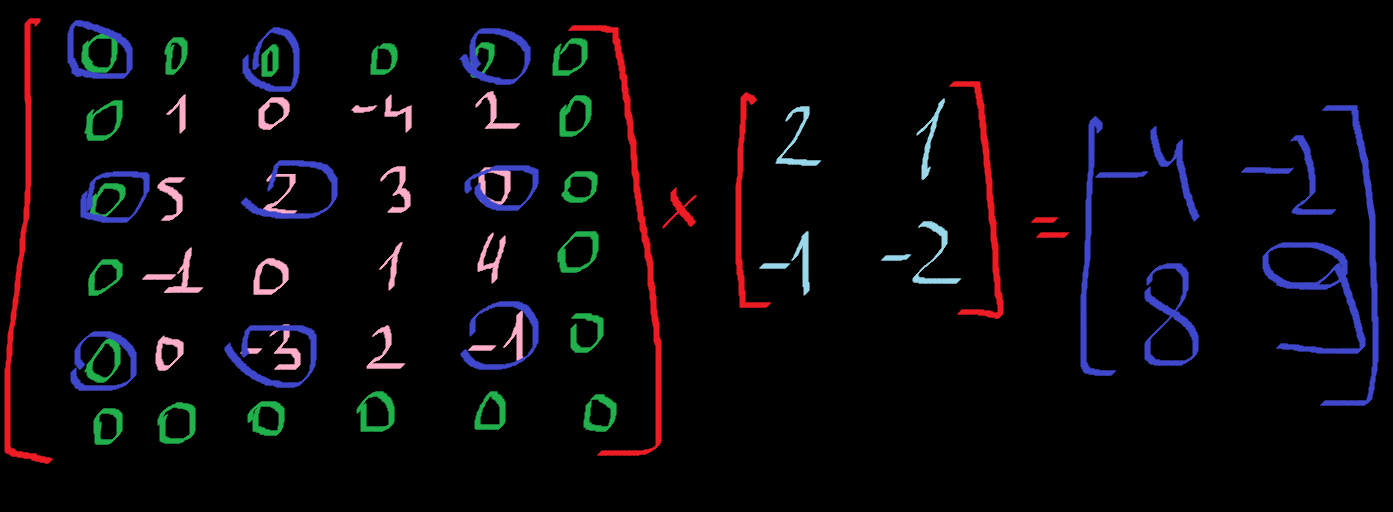


### Problem 2 (2 points)

Count the number of trainable params in nn:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

#### Solution


\begin{align*}
&\text{1. } \text{nn.Conv2d:} \\
&\quad \text{Количество параметров} = \left( \text{in_channels} \times \text{kernel_size} + \text{bias} \right) \times \text{out_channels} \\
&\quad = \left( 3 \times 5 \times 5 + 1 \right) \times 16 \\
&\quad = 1216 \\
\\
&\text{2. } \text{nn.BatchNorm2d (Для каждого признака есть два обучаемых параметра: масштаб и сдвиг):} \\
&\quad \text{Количество параметров} = 2 \times \text{num_features} \\
&\quad = 2 \times 16 \\
&\quad = 32 \\
\\
&\text{3. } \text{nn.LeakyReLU} \text{ и } \text{nn.Sigmoid:} \\
&\quad \text{Эти слои не имеют обучаемых параметров.} \\
\\
&\text{4. } \text{nn.Conv2d:} \\
&\quad \text{Количество параметров} = \left( \text{in_channels} \times \text{kernel_size} \right) \times \text{out_channels} \\
&\quad = \left( 16 \times 5 \times 5 \right) \times 32 \\
&\quad = 12800 \\
\\
&\text{Итак, общее количество обучаемых параметров:} \\
&\quad 1216 + 32 + 12800 = 14048
\end{align*}


### Practical problem


Solve multicalss classification problem for Food101 dataset

####  Helper code

In [2]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import albumentations as A

from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)

In [3]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [4]:
!ls /kaggle/input/food101/food-101

README.txt  images  license_agreement.txt  meta


In [5]:
root = '/kaggle/input/food101/food-101/images'
meta = '/kaggle/input/food101/food-101/meta'

### Dataloaders (1 point)


# Определим пути к tain и test датасетам: они находятся в соответствующих файлах, нужно лишь добавть в конце .jpg что бы получились точные названия

In [6]:
#meta = os.path.join(dataset_path, "meta")
train_txt = meta + '/train.txt'
test_txt = meta + '/test.txt'
train = []
test = []
with open(train_txt, 'r') as ptr:
  train = ptr.read().splitlines()
with open(test_txt, 'r') as ptr:
  test = ptr.read().splitlines()
train_path = [root+'/'+x+'.jpg' for x in train]
test_path = [root+'/'+x+'.jpg' for x in test]

Отрисуем что там вообще находится:

In [7]:
import matplotlib.pyplot as plt
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [79]:
train_path[0:10]

['/kaggle/input/food101/food-101/images/apple_pie/1005649.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1014775.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1026328.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1028787.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1043283.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1050519.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1057749.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1057810.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1072416.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/1074856.jpg']

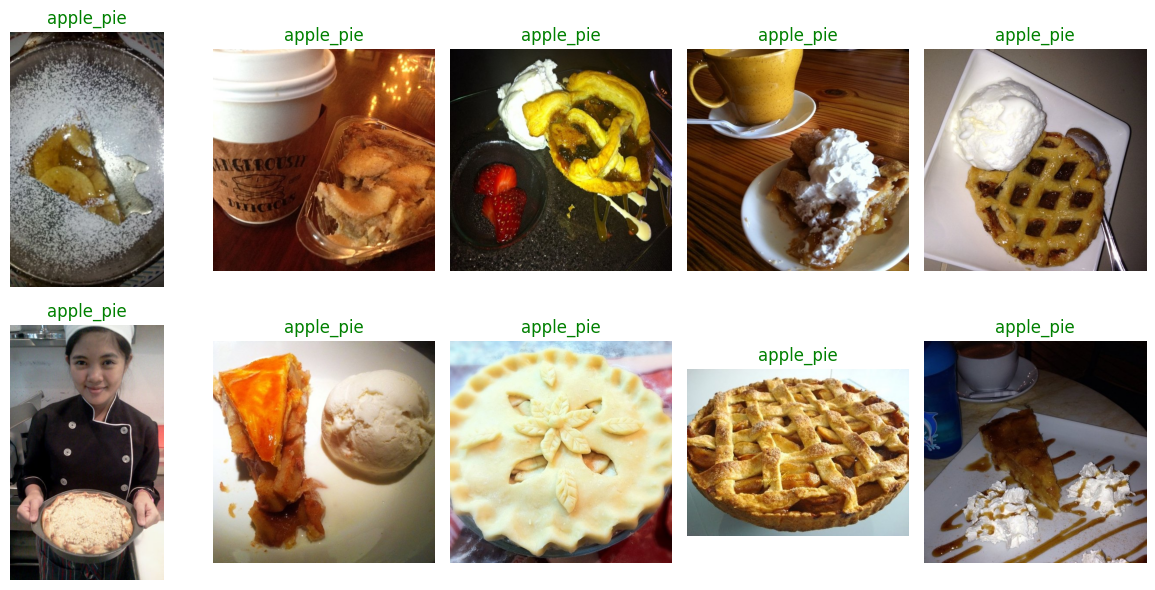

In [80]:
display_image_grid(train_path[0:10])

Читаем файл с названиями классов

In [9]:
classes_txt = meta + '/classes.txt'
classes = []
with open(classes_txt, 'r') as ptr:
  classes = ptr.read().splitlines()

Он понадобится ниже для разметки

In [10]:
class FoodDataSet (Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = classes.index(os.path.normpath(image_filepath).split(os.sep)[-2])
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [11]:
NUM_WORKERS = os.cpu_count()
from torchvision.datasets import ImageFolder

def split_data(dataset, val_size=0.2, seed=42):
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)
    return train_data, test_data

def create_dataloaders(train_path: str, test_path: str, transform_train: A.Compose, transform_test: A.Compose, batch_size: int, num_workers: int=NUM_WORKERS):
  train_dataset = FoodDataSet(train_path, transform_train)
  test_dataset = FoodDataSet(test_path, transform_test)
  '''
  dataset = ImageFolder(root=root)
  train_set, test_data = split_data(dataset)
  train_set.dataset.transform = transform_train
  test_data.dataset.transform = transform_test
  '''
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader

In [12]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

Define transforms. You can add augmentations for better perfomance.

 You can either use Albumentation or torchvision

Don't forget to normalize images

In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose(
  [
    A.SmallestMaxSize(max_size=160),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomCrop(height=128, width=128),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ]
  )

test_transforms = A.Compose(
  [
    A.SmallestMaxSize(max_size=160),
    A.CenterCrop(height=128, width=128),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
  ])

In [14]:
batch_size = 32 
num_workers = 2

# Сохраним 100 рандомных картинок для итоговой проверки

In [15]:
import random
random.seed(42)
test = random.sample(test_path, 100)

In [16]:
test

['/kaggle/input/food101/food-101/images/red_velvet_cake/3749302.jpg',
 '/kaggle/input/food101/food-101/images/carrot_cake/3175778.jpg',
 '/kaggle/input/food101/food-101/images/beef_carpaccio/1864287.jpg',
 '/kaggle/input/food101/food-101/images/takoyaki/1615290.jpg',
 '/kaggle/input/food101/food-101/images/falafel/125492.jpg',
 '/kaggle/input/food101/food-101/images/dumplings/1343111.jpg',
 '/kaggle/input/food101/food-101/images/cup_cakes/1889695.jpg',
 '/kaggle/input/food101/food-101/images/chicken_curry/194828.jpg',
 '/kaggle/input/food101/food-101/images/tacos/3029995.jpg',
 '/kaggle/input/food101/food-101/images/caprese_salad/2353043.jpg',
 '/kaggle/input/food101/food-101/images/seaweed_salad/3385157.jpg',
 '/kaggle/input/food101/food-101/images/takoyaki/1206992.jpg',
 '/kaggle/input/food101/food-101/images/paella/2500393.jpg',
 '/kaggle/input/food101/food-101/images/caesar_salad/239163.jpg',
 '/kaggle/input/food101/food-101/images/pork_chop/240531.jpg',
 '/kaggle/input/food101/foo

In [17]:
len(test_path)

25250

In [18]:
test_path = [x for x in test_path if x not in test]

In [19]:
len(test_path)

25150

In [20]:
train_loader, test_loader = create_dataloaders(train_path, test_path, train_transforms, test_transforms, batch_size)

In [21]:
test = FoodDataSet(test, test_transforms)

 #### Train function (2 points)




In [22]:
def calculate_accuracy(output, target):
    _, predicted = torch.max(output, dim=1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    accuracy = correct / total
    return accuracy

In [23]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_acc = 0
    train_loss = 0
    for i, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      output = model(inputs)

      loss = loss_fn(output, labels.long())
      loss.backward()
      optimizer.step()
      accuracy = calculate_accuracy(output, labels)
      train_acc += accuracy
      train_loss += loss.item()
    return (train_loss/len(dataloader), train_acc/len(dataloader))

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()
    test_acc = 0
    test_loss = 0 
    best_acc = - np.inf 
    best_weights = None
    with torch.no_grad():
      for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        output = model(inputs)
        loss = loss_fn(output, labels.long())
        accuracy = calculate_accuracy(output, labels)
        test_acc += accuracy
        test_loss += loss.item()

    return (test_loss/len(dataloader), test_acc/len(dataloader))



def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    # YOUR CODE HERE#

    # Loop through training and testing steps for a number of epochs
    best_acc = - np.inf 
    best_weights = None
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_weights = copy.deepcopy(model.state_dict())

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary

        results['train_loss'].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        model.load_state_dict(best_weights)
        torch.save({
                'epoch': epochs,
                #'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    # Return the filled results at the end of the epochs
    return results

Choose a model

# Сначала попробуем Efficient net

In [17]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
EN_model = EfficientNet.from_pretrained('efficientnet-b0')

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9ee799c3b754296e56e2aeccc2071c526b69808c968ae5d9039e71bc2ad1fc4f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 159MB/s]

Loaded pretrained weights for efficientnet-b0


Froze several layers or tune whole model

Замораживаем все слои:

In [18]:
for param in EN_model.parameters():
    param.requires_grad = False

Делаем последний слой с классификацией на 101 объект

In [19]:
num_ftrs = EN_model._fc.in_features
EN_model._fc = nn.Linear(num_ftrs, 101)

Размораживаем линейные слои и последний сверточный

In [20]:
for param in EN_model._conv_head.parameters():
    param.requires_grad = True

# Разморозить все линейные слои
for param in EN_model._fc.parameters():
    param.requires_grad = True

Model summary

In [21]:
summary(EN_model,
        input_size=(64, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 256, 256]    [64, 101]            --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [64, 3, 256, 256]    [64, 32, 128, 128]   864                  False
│    └─ZeroPad2d (static_padding)                            [64, 3, 256, 256]    [64, 3, 257, 257]    --                   --
├─BatchNorm2d (_bn0)                                         [64, 32, 128, 128]   [64, 32, 128, 128]   (64)                 False
├─MemoryEfficientSwish (_swish)                              [64, 32, 128, 128]   [64, 32, 128, 128]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   False
│    └─MBConvBlock (0)                                       [64, 32, 128, 128]   [64, 16,

# Теперь время ResNet 50

In [50]:
resnet_model = models.resnet50(pretrained=True)

In [51]:
for param in resnet_model.parameters():
    param.requires_grad = False

In [52]:
# Находим индекс последнего слоя второго блока "bottleneck"
bottleneck2_idx = 14  # Индекс слоя после второго блока "bottleneck"

# Размораживаем последние части слоев в layer4 после bottleneck2
for idx, (name, param) in enumerate(resnet_model.layer4.named_parameters()):
    if idx >= bottleneck2_idx:
        param.requires_grad = True

In [53]:
num_features = resnet_model.fc.in_features

resnet_model.fc = nn.Linear(num_features, 101)

In [54]:
summary(resnet_model,
        input_size=(64, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 256, 256]    [64, 101]            --                   Partial
├─Conv2d (conv1)                         [64, 3, 256, 256]    [64, 64, 128, 128]   (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 128, 128]   [64, 64, 128, 128]   (128)                False
├─ReLU (relu)                            [64, 64, 128, 128]   [64, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 128, 128]   [64, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [64, 64, 64, 64]     [64, 256, 64, 64]    --                   False
│    └─Bottleneck (0)                    [64, 64, 64, 64]     [64, 256, 64, 64]    --                   False
│    │    └─Conv2d (conv1)               [64, 64, 64, 64]     [64, 64, 64, 64]     (4,096)              False
│    │    

# VGG 19

In [64]:
VGG = models.vgg19(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 169MB/s]  


In [80]:
for param in VGG.parameters():
    param.requires_grad = False

In [81]:
num_features = VGG.classifier[-1].in_features
VGG.classifier[-1] = nn.Linear(num_features, 101)

In [82]:
for param in VGG.features[32].parameters():
    param.requires_grad = True
for param in VGG.features[34].parameters():
    param.requires_grad = True

In [83]:
summary(VGG,
        input_size=(64, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [64, 3, 256, 256]    [64, 101]            --                   Partial
├─Sequential (features)                  [64, 3, 256, 256]    [64, 512, 8, 8]      --                   Partial
│    └─Conv2d (0)                        [64, 3, 256, 256]    [64, 64, 256, 256]   (1,792)              False
│    └─ReLU (1)                          [64, 64, 256, 256]   [64, 64, 256, 256]   --                   --
│    └─Conv2d (2)                        [64, 64, 256, 256]   [64, 64, 256, 256]   (36,928)             False
│    └─ReLU (3)                          [64, 64, 256, 256]   [64, 64, 256, 256]   --                   --
│    └─MaxPool2d (4)                     [64, 64, 256, 256]   [64, 64, 128, 128]   --                   --
│    └─Conv2d (5)                        [64, 64, 128, 128]   [64, 128, 128, 128]  (73,856)             False
│    └─ReLU

# ResNet 101

P.S. я почему то его назвал резнет 90 =)))

In [24]:
resnet_90_model = models.resnet101(pretrained=True)

In [25]:
for param in resnet_90_model.parameters():
    param.requires_grad = False

In [33]:
# Находим индекс последнего слоя второго блока "bottleneck"
bottleneck2_idx = 14  # Индекс слоя после второго блока "bottleneck"

# Размораживаем последние части слоев в layer4 после bottleneck2
for idx, (name, param) in enumerate(resnet_90_model.layer4.named_parameters()):
    if idx >= bottleneck2_idx:
        param.requires_grad = True

In [29]:
num_features = resnet_90_model.fc.in_features

resnet_90_model.fc = nn.Linear(num_features, 101)

In [35]:
summary(resnet_90_model,
        input_size=(128, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 3, 256, 256]   [128, 101]           --                   Partial
├─Conv2d (conv1)                         [128, 3, 256, 256]   [128, 64, 128, 128]  (9,408)              False
├─BatchNorm2d (bn1)                      [128, 64, 128, 128]  [128, 64, 128, 128]  (128)                False
├─ReLU (relu)                            [128, 64, 128, 128]  [128, 64, 128, 128]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 128, 128]  [128, 64, 64, 64]    --                   --
├─Sequential (layer1)                    [128, 64, 64, 64]    [128, 256, 64, 64]   --                   False
│    └─Bottleneck (0)                    [128, 64, 64, 64]    [128, 256, 64, 64]   --                   False
│    │    └─Conv2d (conv1)               [128, 64, 64, 64]    [128, 64, 64, 64]    (4,096)              False
│    │    

# ResNet 101 дубль два

In [69]:
resnet_101_model = models.resnet101(pretrained=True)
for param in resnet_101_model.parameters():
    param.requires_grad = False
# Находим индекс последнего слоя второго блока "bottleneck"
bottleneck2_idx = 8  # Индекс слоя после второго блока "bottleneck"

# Размораживаем последние части слоев в layer4 после bottleneck2
for idx, (name, param) in enumerate(resnet_101_model.layer4.named_parameters()):
    if idx >= bottleneck2_idx:
        param.requires_grad = True
num_features = resnet_101_model.fc.in_features

In [70]:
resnet_101_model.fc = nn.Linear(num_features, 101)

summary(resnet_101_model,
        input_size=(64, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 256, 256]    [64, 101]            --                   Partial
├─Conv2d (conv1)                         [64, 3, 256, 256]    [64, 64, 128, 128]   (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 128, 128]   [64, 64, 128, 128]   (128)                False
├─ReLU (relu)                            [64, 64, 128, 128]   [64, 64, 128, 128]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 128, 128]   [64, 64, 64, 64]     --                   --
├─Sequential (layer1)                    [64, 64, 64, 64]     [64, 256, 64, 64]    --                   False
│    └─Bottleneck (0)                    [64, 64, 64, 64]     [64, 256, 64, 64]    --                   False
│    │    └─Conv2d (conv1)               [64, 64, 64, 64]     [64, 64, 64, 64]     (4,096)              False
│    │    

# Все не то, теперь эфишент нет b5 и + добавим в оптимайзер динамический lr!


In [24]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=96108b9adb0d0797ea05ee9ef5ad6b36c036dce9f06a49be6b27a8957d4cbada
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [25]:
EN_model = EfficientNet.from_pretrained('efficientnet-b5')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 284MB/s] 


Loaded pretrained weights for efficientnet-b5


In [28]:
for name, param in EN_model.named_parameters():
    if '_bn1' in name or '_conv_head' in name or 'blocks.37' in name or 'blocks.38' in name or 'blocks.39' in name or 'blocks.40' in name or 'blocks.41' in name or 'blocks.42' in name or 'blocks.43' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [29]:
num_ftrs = EN_model._fc.in_features  # Получаем количество входных признаков для последнего слоя
EN_model._fc = nn.Linear(num_ftrs, 101) 

In [30]:
summary(EN_model,
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 256, 256]    [32, 101]            --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 256, 256]    [32, 48, 128, 128]   1,296                False
│    └─ZeroPad2d (static_padding)                            [32, 3, 256, 256]    [32, 3, 257, 257]    --                   --
├─BatchNorm2d (_bn0)                                         [32, 48, 128, 128]   [32, 48, 128, 128]   (96)                 False
├─MemoryEfficientSwish (_swish)                              [32, 48, 128, 128]   [32, 48, 128, 128]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   Partial
│    └─MBConvBlock (0)                                       [32, 48, 128, 128]   [32, 2

### Train (1 point)

Efficient Net

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=0.001)
n_epochs = 25

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=EN_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7023 | train_acc: 0.3693 | test_loss: 1.8933 | test_acc: 0.5188
Epoch: 2 | train_loss: 2.2857 | train_acc: 0.4407 | test_loss: 1.7746 | test_acc: 0.5451
Epoch: 3 | train_loss: 2.1749 | train_acc: 0.4607 | test_loss: 1.7174 | test_acc: 0.5584
Epoch: 4 | train_loss: 2.0854 | train_acc: 0.4818 | test_loss: 1.6770 | test_acc: 0.5701
Epoch: 5 | train_loss: 2.0313 | train_acc: 0.4920 | test_loss: 1.6566 | test_acc: 0.5757
Epoch: 6 | train_loss: 1.9889 | train_acc: 0.5024 | test_loss: 1.6440 | test_acc: 0.5782
Epoch: 7 | train_loss: 1.9505 | train_acc: 0.5087 | test_loss: 1.6425 | test_acc: 0.5781
Epoch: 8 | train_loss: 1.9199 | train_acc: 0.5162 | test_loss: 1.6141 | test_acc: 0.5859
Epoch: 9 | train_loss: 1.8919 | train_acc: 0.5202 | test_loss: 1.6078 | test_acc: 0.5879
Epoch: 10 | train_loss: 1.8734 | train_acc: 0.5231 | test_loss: 1.6041 | test_acc: 0.5861
Epoch: 11 | train_loss: 1.8471 | train_acc: 0.5287 | test_loss: 1.6095 | test_acc: 0.5876
Epoch: 12 | train_l

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
n_epochs = 25

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [57]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_resnet = train(model=resnet_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3536 | train_acc: 0.4220 | test_loss: 1.5498 | test_acc: 0.5889
Epoch: 2 | train_loss: 1.7851 | train_acc: 0.5436 | test_loss: 1.3604 | test_acc: 0.6341
Epoch: 3 | train_loss: 1.5877 | train_acc: 0.5873 | test_loss: 1.2993 | test_acc: 0.6523
Epoch: 4 | train_loss: 1.4456 | train_acc: 0.6187 | test_loss: 1.2508 | test_acc: 0.6679
Epoch: 5 | train_loss: 1.3348 | train_acc: 0.6451 | test_loss: 1.2100 | test_acc: 0.6774
Epoch: 6 | train_loss: 1.2353 | train_acc: 0.6679 | test_loss: 1.1906 | test_acc: 0.6866
Epoch: 7 | train_loss: 1.1517 | train_acc: 0.6870 | test_loss: 1.1830 | test_acc: 0.6873
Epoch: 8 | train_loss: 1.0764 | train_acc: 0.7052 | test_loss: 1.1766 | test_acc: 0.6890
Epoch: 9 | train_loss: 1.0009 | train_acc: 0.7241 | test_loss: 1.1940 | test_acc: 0.6883
Epoch: 10 | train_loss: 0.9386 | train_acc: 0.7377 | test_loss: 1.2204 | test_acc: 0.6899
Epoch: 11 | train_loss: 0.8831 | train_acc: 0.7503 | test_loss: 1.2238 | test_acc: 0.6905
Epoch: 12 | train_l

# VGG

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG.parameters(), lr=0.001)
n_epochs = 25

Остановил раньше, потому что не училось

In [85]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_VGG = train(model=VGG,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.0846 | train_acc: 0.2695 | test_loss: 2.2563 | test_acc: 0.4540
Epoch: 2 | train_loss: 2.5539 | train_acc: 0.3825 | test_loss: 2.1117 | test_acc: 0.4891
Epoch: 3 | train_loss: 2.3955 | train_acc: 0.4181 | test_loss: 2.0031 | test_acc: 0.5114
Epoch: 4 | train_loss: 2.2912 | train_acc: 0.4411 | test_loss: 2.0299 | test_acc: 0.5143
Epoch: 5 | train_loss: 2.2106 | train_acc: 0.4603 | test_loss: 1.8717 | test_acc: 0.5444
Epoch: 6 | train_loss: 2.1652 | train_acc: 0.4699 | test_loss: 1.8194 | test_acc: 0.5486
Epoch: 7 | train_loss: 2.1215 | train_acc: 0.4797 | test_loss: 1.8565 | test_acc: 0.5464
Epoch: 8 | train_loss: 2.0797 | train_acc: 0.4879 | test_loss: 1.7928 | test_acc: 0.5606
Epoch: 9 | train_loss: 2.0511 | train_acc: 0.4976 | test_loss: 1.8615 | test_acc: 0.5545


KeyboardInterrupt: 

# Resnet 101

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_90_model.parameters(), lr=0.001)
n_epochs = 25

In [38]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_resnet_90 = train(model=resnet_90_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3832 | train_acc: 0.4141 | test_loss: 1.6185 | test_acc: 0.5736
Epoch: 2 | train_loss: 1.7908 | train_acc: 0.5421 | test_loss: 1.3939 | test_acc: 0.6261
Epoch: 3 | train_loss: 1.5856 | train_acc: 0.5883 | test_loss: 1.3437 | test_acc: 0.6382
Epoch: 4 | train_loss: 1.4444 | train_acc: 0.6185 | test_loss: 1.2759 | test_acc: 0.6600
Epoch: 5 | train_loss: 1.3314 | train_acc: 0.6449 | test_loss: 1.2532 | test_acc: 0.6642
Epoch: 6 | train_loss: 1.2381 | train_acc: 0.6690 | test_loss: 1.2540 | test_acc: 0.6674
Epoch: 7 | train_loss: 1.1560 | train_acc: 0.6870 | test_loss: 1.2206 | test_acc: 0.6764
Epoch: 8 | train_loss: 1.0773 | train_acc: 0.7052 | test_loss: 1.2233 | test_acc: 0.6783
Epoch: 9 | train_loss: 1.0059 | train_acc: 0.7203 | test_loss: 1.2537 | test_acc: 0.6775


KeyboardInterrupt: 

# ResNet 101 дубль два

In [80]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_101_model.parameters(), lr=0.001)
n_epochs = 20

In [81]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_resnet_101 = train(model=resnet_101_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3548 | train_acc: 0.4199 | test_loss: 1.5420 | test_acc: 0.5943
Epoch: 2 | train_loss: 1.7542 | train_acc: 0.5524 | test_loss: 1.3551 | test_acc: 0.6347
Epoch: 3 | train_loss: 1.5544 | train_acc: 0.5977 | test_loss: 1.2341 | test_acc: 0.6666
Epoch: 4 | train_loss: 1.4113 | train_acc: 0.6298 | test_loss: 1.1730 | test_acc: 0.6856
Epoch: 5 | train_loss: 1.2986 | train_acc: 0.6540 | test_loss: 1.1348 | test_acc: 0.6924
Epoch: 6 | train_loss: 1.2051 | train_acc: 0.6783 | test_loss: 1.1097 | test_acc: 0.7031
Epoch: 7 | train_loss: 1.1226 | train_acc: 0.6962 | test_loss: 1.1088 | test_acc: 0.7054
Epoch: 8 | train_loss: 1.0465 | train_acc: 0.7148 | test_loss: 1.0811 | test_acc: 0.7100
Epoch: 9 | train_loss: 0.9739 | train_acc: 0.7327 | test_loss: 1.0890 | test_acc: 0.7097
Epoch: 10 | train_loss: 0.9117 | train_acc: 0.7473 | test_loss: 1.1141 | test_acc: 0.7063
Epoch: 11 | train_loss: 0.8514 | train_acc: 0.7615 | test_loss: 1.1073 | test_acc: 0.7098
Epoch: 12 | train_l

# Эфишент нет b5 


In [29]:
from torch.optim import lr_scheduler

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.7) # добавим lr-reductor))
n_epochs = 20

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_EN = train(model=EN_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5780 | train_acc: 0.3765 | test_loss: 1.7835 | test_acc: 0.5555
Epoch: 2 | train_loss: 1.9149 | train_acc: 0.5186 | test_loss: 1.5089 | test_acc: 0.6057
Epoch: 3 | train_loss: 1.7352 | train_acc: 0.5584 | test_loss: 1.2709 | test_acc: 0.6600
Epoch: 4 | train_loss: 1.6181 | train_acc: 0.5861 | test_loss: 1.4374 | test_acc: 0.6353
Epoch: 5 | train_loss: 1.5468 | train_acc: 0.6037 | test_loss: 1.2486 | test_acc: 0.6728
Epoch: 6 | train_loss: 1.4815 | train_acc: 0.6161 | test_loss: 1.2208 | test_acc: 0.6839
Epoch: 7 | train_loss: 1.4280 | train_acc: 0.6308 | test_loss: 1.1390 | test_acc: 0.7040
Epoch: 8 | train_loss: 1.3764 | train_acc: 0.6416 | test_loss: 1.1631 | test_acc: 0.6969
Epoch: 9 | train_loss: 1.3366 | train_acc: 0.6524 | test_loss: 1.0679 | test_acc: 0.7145
Epoch: 10 | train_loss: 1.2950 | train_acc: 0.6585 | test_loss: 1.1537 | test_acc: 0.7066
Epoch: 11 | train_loss: 1.2586 | train_acc: 0.6676 | test_loss: 1.1067 | test_acc: 0.7107
Epoch: 12 | train_l

# еще одна попытка

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(EN_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.75) # добавим lr-reductor))
n_epochs = 10

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_EN = train(model=EN_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5851 | train_acc: 0.3741 | test_loss: 1.8725 | test_acc: 0.5434
Epoch: 2 | train_loss: 1.9101 | train_acc: 0.5181 | test_loss: 1.4683 | test_acc: 0.6181
Epoch: 3 | train_loss: 1.7359 | train_acc: 0.5584 | test_loss: 1.3372 | test_acc: 0.6473
Epoch: 4 | train_loss: 1.6167 | train_acc: 0.5867 | test_loss: 1.3122 | test_acc: 0.6592
Epoch: 5 | train_loss: 1.5443 | train_acc: 0.6031 | test_loss: 1.3106 | test_acc: 0.6636
Epoch: 6 | train_loss: 1.4839 | train_acc: 0.6171 | test_loss: 1.1995 | test_acc: 0.6812
Epoch: 7 | train_loss: 1.4257 | train_acc: 0.6287 | test_loss: 1.1887 | test_acc: 0.6927
Epoch: 8 | train_loss: 1.3768 | train_acc: 0.6422 | test_loss: 1.1048 | test_acc: 0.7116
Epoch: 9 | train_loss: 1.3413 | train_acc: 0.6494 | test_loss: 1.1012 | test_acc: 0.7122
Epoch: 10 | train_loss: 1.3022 | train_acc: 0.6590 | test_loss: 1.1369 | test_acc: 0.7043
[INFO] Total training time: 6222.144 seconds


In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_EN = train(model=EN_model,
                       train_dataloader=train_loader,
                       test_dataloader=test_loader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8440 | train_acc: 0.3393 | test_loss: 1.7184 | test_acc: 0.5525
Epoch: 2 | train_loss: 2.2603 | train_acc: 0.4534 | test_loss: 1.5709 | test_acc: 0.5890
Epoch: 3 | train_loss: 2.1278 | train_acc: 0.4822 | test_loss: 1.5273 | test_acc: 0.6039
Epoch: 4 | train_loss: 2.0148 | train_acc: 0.5056 | test_loss: 1.3941 | test_acc: 0.6312
Epoch: 5 | train_loss: 1.9572 | train_acc: 0.5169 | test_loss: 1.4338 | test_acc: 0.6224
Epoch: 6 | train_loss: 1.9579 | train_acc: 0.5173 | test_loss: 1.5546 | test_acc: 0.5917


KeyboardInterrupt: 

### Results (2 points in total)
Plot train and val losses

Inference model on unique subset of images


It must be very obvious that you specificaly using images that model has never seen neither during training nor evaluation steps




#### Graphs (1 point)
Plot graphs for train and val loss



In [34]:
def plot_training_history(histories, model_names):
    plt.figure(figsize=(12, 6), facecolor='lightgrey')
    
    # График потерь на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 1)
    colors = ['blue', 'red', 'green', 'orange']  # Список цветов для графиков
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], '--', color=color, label=f'Training loss - {name}')
        plt.plot(epochs, history['test_loss'], color=color, label=f'Validation loss - {name}')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # График точности на обучающем и тестовом наборах данных
    plt.subplot(1, 2, 2)
    for history, name, color in zip(histories, model_names, colors):
        epochs = range(1, len(history['train_acc']) + 1)
        plt.plot(epochs, history['train_acc'], '--', color=color, label=f'Training accuracy - {name}')
        plt.plot(epochs, history['test_acc'], color=color, label=f'Validation accuracy - {name}')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle('Training History')
    plt.tight_layout()
    plt.show()

# это я обучал alexnet на 10 эпохах без гпу) жалко я не сохранил все дикты от других обучений..

In [35]:
alex_net = {'train_loss': [4.240959445165621,
  4.11446617503424,
  4.109741011181393,
  4.150661240155633,
  4.150760450878659,
  4.194993057565109,
  4.176952967772612,
  4.210374249598464,
  4.229898835758905,
  4.236192132975604],
 'train_acc': [0.23287334415007113,
  0.269255506534495,
  0.28372891291785207,
  0.29191092305298716,
  0.29820579214082504,
  0.2986808766002845,
  0.3055439022492888,
  0.30715807810277385,
  0.3089792351973684,
  0.31334251089082504],
 'test_loss': [3.325643151583551,
  3.459687038539331,
  3.577775663891925,
  3.6356711817693106,
  3.7073544536964804,
  3.7408680644970906,
  3.8005975976774966,
  3.9152759121188634,
  3.873568640592732,
  3.9591971805578545],
 'test_acc': [0.33555472822040205,
  0.33579206999255395,
  0.34788719285182423,
  0.3478965003723008,
  0.34541371928518244,
  0.3474799888309755,
  0.35095634772896506,
  0.337022989575577,
  0.3468191548771407,
  0.3457162137006701]}

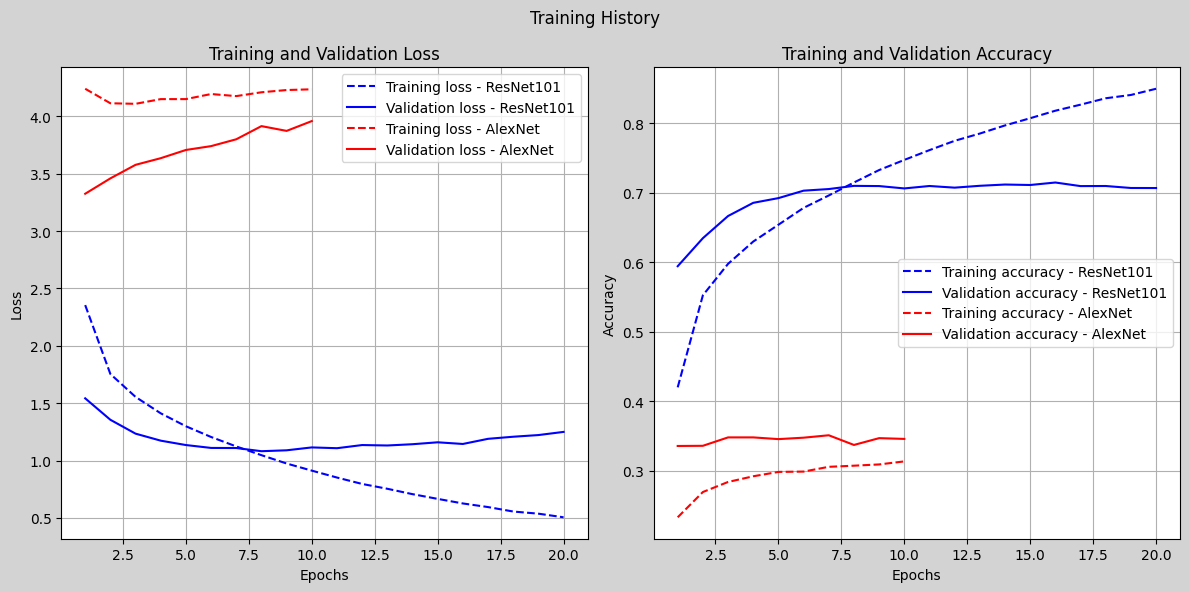

In [84]:
plot_training_history([results_resnet_101, alex_net], ['ResNet101', 'AlexNet'])

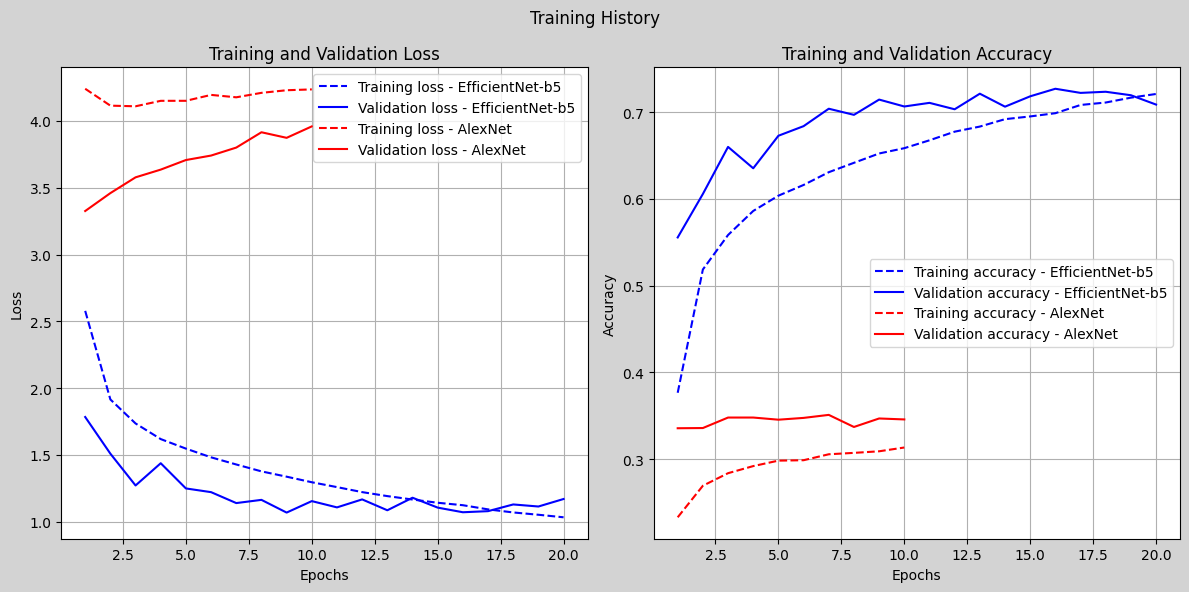

In [33]:
plot_training_history([results_EN, alex_net], ['EfficientNet-b5', 'AlexNet'])

#### Demonstration (1 point)

Show model prediction on several images

In [37]:
results_EN = {'train_loss': [2.5779995811549394,
  1.9148909182765999,
  1.7351576470946137,
  1.6181095003376942,
  1.5467662573162768,
  1.4815124152479946,
  1.4279878437015656,
  1.376404205286825,
  1.3366452201798156,
  1.2949891172953554,
  1.2585738214185915,
  1.2211120020396806,
  1.1912211735506315,
  1.1655475510334647,
  1.1413879475581485,
  1.1230655050760991,
  1.0918496381491423,
  1.0689211217434824,
  1.051579804335897,
  1.0325712257543125],
 'train_acc': [0.37645581436699854,
  0.5186213660206259,
  0.558370099128734,
  0.5860916940789473,
  0.6037135768581081,
  0.6160748021870555,
  0.6307815833926032,
  0.6416154538584637,
  0.6523666707414651,
  0.6584837304409673,
  0.6675645114687055,
  0.6775114186966572,
  0.6834013546852774,
  0.6919403727329303,
  0.6950937111041963,
  0.6988061766536273,
  0.708313422386202,
  0.7111285061788762,
  0.7167322801831436,
  0.7209872032805832],
 'test_loss': [1.7834707459686063,
  1.50887463045598,
  1.2708664941423722,
  1.437356458579927,
  1.2486209131992936,
  1.2207990564955706,
  1.1390239162792384,
  1.1630884779868387,
  1.0678672824462558,
  1.1537422977823943,
  1.1067384564277476,
  1.1665431917491003,
  1.085127606883683,
  1.1791245646717894,
  1.105049476823734,
  1.0703182370750277,
  1.0785370479709926,
  1.1287278669670642,
  1.1133485827358018,
  1.1695331469102368],
 'test_acc': [0.5555499979479602,
  0.6056967187884758,
  0.659961626857096,
  0.6353063695313141,
  0.6728215033243043,
  0.6838730197816629,
  0.7039817265862267,
  0.6969162972995158,
  0.7145176680620536,
  0.7065608840187145,
  0.710736784864155,
  0.7033532894196832,
  0.721304789460724,
  0.7063390072231799,
  0.7182870085364853,
  0.7269966346548469,
  0.7222294898629237,
  0.7235415127636871,
  0.7195323401461051,
  0.7087501539029796]}

In [36]:
test_path = ['/kaggle/input/food101/food-101/images/red_velvet_cake/3749302.jpg',
 '/kaggle/input/food101/food-101/images/carrot_cake/3175778.jpg',
 '/kaggle/input/food101/food-101/images/beef_carpaccio/1864287.jpg',
 '/kaggle/input/food101/food-101/images/takoyaki/1615290.jpg',
 '/kaggle/input/food101/food-101/images/falafel/125492.jpg',
 '/kaggle/input/food101/food-101/images/dumplings/1343111.jpg',
 '/kaggle/input/food101/food-101/images/cup_cakes/1889695.jpg',
 '/kaggle/input/food101/food-101/images/chicken_curry/194828.jpg',
 '/kaggle/input/food101/food-101/images/tacos/3029995.jpg',
 '/kaggle/input/food101/food-101/images/caprese_salad/2353043.jpg',
 '/kaggle/input/food101/food-101/images/seaweed_salad/3385157.jpg',
 '/kaggle/input/food101/food-101/images/takoyaki/1206992.jpg',
 '/kaggle/input/food101/food-101/images/paella/2500393.jpg',
 '/kaggle/input/food101/food-101/images/caesar_salad/239163.jpg',
 '/kaggle/input/food101/food-101/images/pork_chop/240531.jpg',
 '/kaggle/input/food101/food-101/images/hot_dog/1843336.jpg',
 '/kaggle/input/food101/food-101/images/beef_tartare/1571778.jpg',
 '/kaggle/input/food101/food-101/images/beef_carpaccio/720185.jpg',
 '/kaggle/input/food101/food-101/images/cannoli/1982314.jpg',
 '/kaggle/input/food101/food-101/images/croque_madame/336993.jpg',
 '/kaggle/input/food101/food-101/images/deviled_eggs/2672811.jpg',
 '/kaggle/input/food101/food-101/images/nachos/175246.jpg',
 '/kaggle/input/food101/food-101/images/poutine/677155.jpg',
 '/kaggle/input/food101/food-101/images/beef_carpaccio/2527037.jpg',
 '/kaggle/input/food101/food-101/images/panna_cotta/3042741.jpg',
 '/kaggle/input/food101/food-101/images/crab_cakes/1211020.jpg',
 '/kaggle/input/food101/food-101/images/steak/647683.jpg',
 '/kaggle/input/food101/food-101/images/samosa/1793917.jpg',
 '/kaggle/input/food101/food-101/images/spaghetti_carbonara/721661.jpg',
 '/kaggle/input/food101/food-101/images/paella/2319895.jpg',
 '/kaggle/input/food101/food-101/images/hot_and_sour_soup/968546.jpg',
 '/kaggle/input/food101/food-101/images/croque_madame/644072.jpg',
 '/kaggle/input/food101/food-101/images/ice_cream/649649.jpg',
 '/kaggle/input/food101/food-101/images/pork_chop/1928764.jpg',
 '/kaggle/input/food101/food-101/images/falafel/252381.jpg',
 '/kaggle/input/food101/food-101/images/apple_pie/451719.jpg',
 '/kaggle/input/food101/food-101/images/tuna_tartare/2958593.jpg',
 '/kaggle/input/food101/food-101/images/chicken_wings/788545.jpg',
 '/kaggle/input/food101/food-101/images/spaghetti_carbonara/2761253.jpg',
 '/kaggle/input/food101/food-101/images/hot_dog/2202961.jpg',
 '/kaggle/input/food101/food-101/images/fried_rice/2897873.jpg',
 '/kaggle/input/food101/food-101/images/falafel/2382955.jpg',
 '/kaggle/input/food101/food-101/images/chicken_wings/2465533.jpg',
 '/kaggle/input/food101/food-101/images/croque_madame/174645.jpg',
 '/kaggle/input/food101/food-101/images/waffles/1265284.jpg',
 '/kaggle/input/food101/food-101/images/fried_rice/1323164.jpg',
 '/kaggle/input/food101/food-101/images/caprese_salad/2244686.jpg',
 '/kaggle/input/food101/food-101/images/cannoli/1492785.jpg',
 '/kaggle/input/food101/food-101/images/grilled_cheese_sandwich/624881.jpg',
 '/kaggle/input/food101/food-101/images/cannoli/3447820.jpg',
 '/kaggle/input/food101/food-101/images/gnocchi/1214945.jpg',
 '/kaggle/input/food101/food-101/images/frozen_yogurt/1332654.jpg',
 '/kaggle/input/food101/food-101/images/prime_rib/1386254.jpg',
 '/kaggle/input/food101/food-101/images/eggs_benedict/3388732.jpg',
 '/kaggle/input/food101/food-101/images/beet_salad/3440321.jpg',
 '/kaggle/input/food101/food-101/images/sushi/3445331.jpg',
 '/kaggle/input/food101/food-101/images/lobster_bisque/1854982.jpg',
 '/kaggle/input/food101/food-101/images/pad_thai/2034148.jpg',
 '/kaggle/input/food101/food-101/images/cheesecake/2265323.jpg',
 '/kaggle/input/food101/food-101/images/grilled_cheese_sandwich/319161.jpg',
 '/kaggle/input/food101/food-101/images/bruschetta/2394539.jpg',
 '/kaggle/input/food101/food-101/images/pancakes/2256512.jpg',
 '/kaggle/input/food101/food-101/images/fish_and_chips/2486391.jpg',
 '/kaggle/input/food101/food-101/images/ravioli/252131.jpg',
 '/kaggle/input/food101/food-101/images/ramen/1130900.jpg',
 '/kaggle/input/food101/food-101/images/gnocchi/2710993.jpg',
 '/kaggle/input/food101/food-101/images/pho/344698.jpg',
 '/kaggle/input/food101/food-101/images/club_sandwich/1659584.jpg',
 '/kaggle/input/food101/food-101/images/spring_rolls/2080616.jpg',
 '/kaggle/input/food101/food-101/images/breakfast_burrito/1381264.jpg',
 '/kaggle/input/food101/food-101/images/beignets/1017820.jpg',
 '/kaggle/input/food101/food-101/images/sashimi/3325306.jpg',
 '/kaggle/input/food101/food-101/images/cup_cakes/67469.jpg',
 '/kaggle/input/food101/food-101/images/filet_mignon/743874.jpg',
 '/kaggle/input/food101/food-101/images/bruschetta/2692413.jpg',
 '/kaggle/input/food101/food-101/images/deviled_eggs/2763412.jpg',
 '/kaggle/input/food101/food-101/images/caprese_salad/1767671.jpg',
 '/kaggle/input/food101/food-101/images/grilled_cheese_sandwich/657782.jpg',
 '/kaggle/input/food101/food-101/images/falafel/2393585.jpg',
 '/kaggle/input/food101/food-101/images/lasagna/2721326.jpg',
 '/kaggle/input/food101/food-101/images/red_velvet_cake/2011498.jpg',
 '/kaggle/input/food101/food-101/images/gnocchi/562495.jpg',
 '/kaggle/input/food101/food-101/images/chocolate_cake/2410886.jpg',
 '/kaggle/input/food101/food-101/images/greek_salad/3021713.jpg',
 '/kaggle/input/food101/food-101/images/garlic_bread/2956036.jpg',
 '/kaggle/input/food101/food-101/images/creme_brulee/2573868.jpg',
 '/kaggle/input/food101/food-101/images/scallops/515375.jpg',
 '/kaggle/input/food101/food-101/images/eggs_benedict/983260.jpg',
 '/kaggle/input/food101/food-101/images/spaghetti_carbonara/933389.jpg',
 '/kaggle/input/food101/food-101/images/shrimp_and_grits/3197830.jpg',
 '/kaggle/input/food101/food-101/images/risotto/717314.jpg',
 '/kaggle/input/food101/food-101/images/breakfast_burrito/229476.jpg',
 '/kaggle/input/food101/food-101/images/prime_rib/454303.jpg',
 '/kaggle/input/food101/food-101/images/red_velvet_cake/1785850.jpg',
 '/kaggle/input/food101/food-101/images/chocolate_mousse/2448777.jpg',
 '/kaggle/input/food101/food-101/images/pad_thai/1099844.jpg',
 '/kaggle/input/food101/food-101/images/sushi/3268416.jpg',
 '/kaggle/input/food101/food-101/images/dumplings/1308246.jpg',
 '/kaggle/input/food101/food-101/images/chocolate_cake/2697806.jpg',
 '/kaggle/input/food101/food-101/images/lobster_bisque/3010212.jpg']

In [72]:
test_data = FoodDataSet(test_path[0:10], test_transforms)

In [73]:
test_loader = DataLoader(
    test_data,
    batch_size=10,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
  )

In [74]:
EN_model.eval()
with torch.no_grad():
    for _, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        out = EN_model(inputs)
        print('Accuracy: ', calculate_accuracy(out, labels))

Accuracy:  0.8


In [77]:
predicted = torch.max(out, dim=1)

In [84]:
predicted

torch.return_types.max(
values=tensor([14.0817, 11.2140, 12.3295,  9.6052, 11.6433, 21.3252, 11.4557,  7.0054,
        11.6942, 11.2989], device='cuda:0'),
indices=tensor([83, 14,  3, 97, 63, 32, 29, 43, 96, 13], device='cuda:0'))

In [91]:
predicted = [83, 14,  3, 97, 63, 32, 29, 43, 96, 13]

In [92]:
predicted_names = [classes[i] for i in predicted]

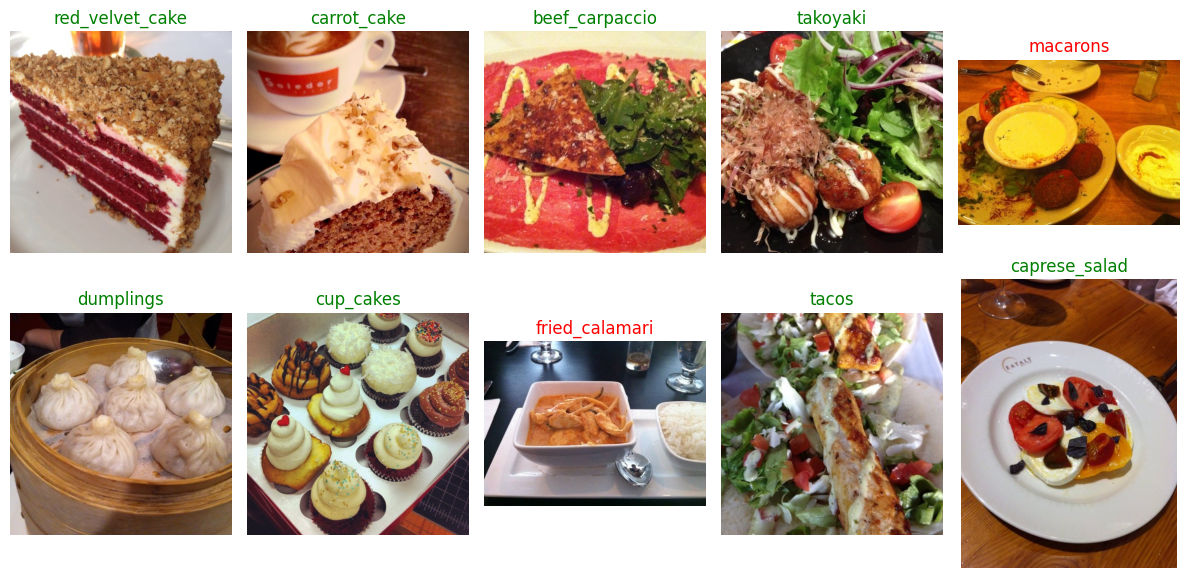

In [93]:
display_image_grid(test_path[:10], predicted_names)

# Tеперь конечный результат на данных которые модель не видела

In [95]:
test_final = FoodDataSet(test_path, test_transforms)
test_final = DataLoader(
    test_final,
    batch_size=100,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
  )

In [96]:
EN_model.eval()
with torch.no_grad():
    for _, data in enumerate(test_final):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        out = EN_model(inputs)
        print('Accuracy: ', calculate_accuracy(out, labels))

Accuracy:  0.71
